# Hamiltonian simulation with Gray code encoding - QASM w/tomography

In [1]:
import warnings
warnings.filterwarnings(action='once')

import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.ignis.verification import tomography

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})

import qutip as qt

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

states_gc = ['00', '10', '11', '01']
states_jw = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

backend = Aer.get_backend('qasm_simulator')

## QASM Simulation with quantum state tomography

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

In [4]:
H_gc = DenseEncodingHamiltonian(N_states=4)

# Get the matrix in "qiskit order"
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [5]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_gc.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

trace_dists_gc = np.zeros(max_trotter_steps)

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    q = QuantumRegister(H_gc.N_qubits)
    
    circuit = QuantumCircuit(q)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
        
    ######################
    #     Tomography     #
    ######################
    tomography_circuits = tomography.state_tomography_circuits(circuit, q)

    tomo_job = execute(tomography_circuits, backend=backend, shots=10000)
    tomo_results = tomo_job.result()

    fitter = tomography.StateTomographyFitter(tomo_results, tomography_circuits)
    density_mat = fitter.fit()
    
    trace_dists_gc[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(density_mat))  

  0%|          | 0/100 [00:00<?, ?it/s]/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STA

Text(0.5, 1.0, 'Gray code, N=4, Hamiltonian evolution time t = 1')

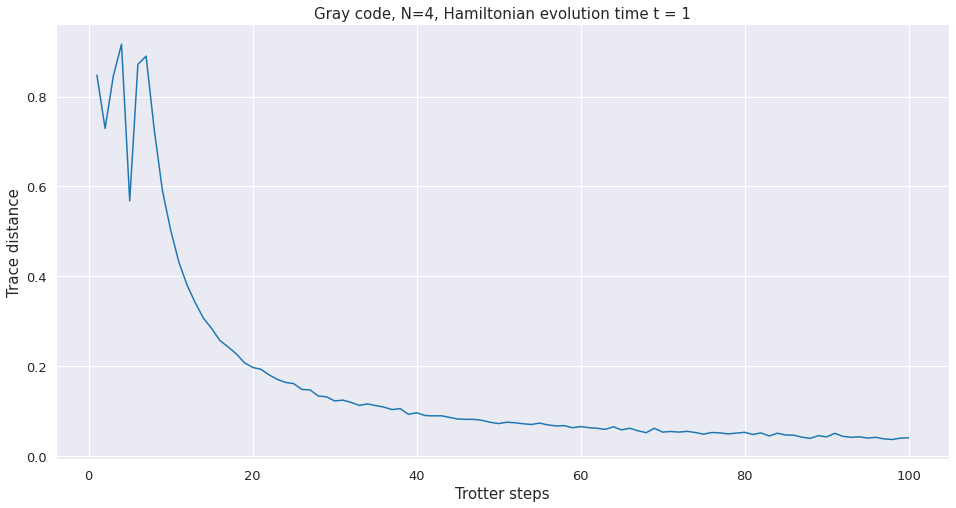

In [6]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue')
plt.xlabel("Trotter steps", fontsize=15)
plt.ylabel("Trace distance", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f"Gray code, N=4, Hamiltonian evolution time t = {T}", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for Jordan-Wigner. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [7]:
jw = SparseEncodingHamiltonian(N_states=4)
jw_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in jw.pauli_coeffs.items()])
uniform_jw = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

exact_wavefunction_jw = unitary_evolution(jw_ham_rep, t=T) @ uniform_jw

In [ ]:
H_jw = SparseEncodingHamiltonian(N_states=4, qiskit_order=True)
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_jw.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

trace_dists_jw = np.zeros(max_trotter_steps)

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Construct uniform superposition over spherical coordinates
    q = QuantumRegister(H_jw.N_qubits)
    
    circuit = QuantumCircuit(q)
    circuit.x(q[0])
    circuit.ry(θ_1, q[1])
    circuit.cx(q[1], q[0])
    circuit.cry(θ_2, q[1], q[2])
    circuit.cx(q[2], q[1])
    circuit.cry(θ_3, q[2], q[3])
    circuit.cx(q[3], q[2])
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    ######################
    #     Tomography     #
    ######################
    tomography_circuits = tomography.state_tomography_circuits(circuit, q)

    tomo_job = execute(tomography_circuits, backend=backend, shots=10000)
    tomo_results = tomo_job.result()

    fitter = tomography.StateTomographyFitter(tomo_results, tomography_circuits)
    density_mat = fitter.fit()
    
    trace_dists_jw[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_jw), qt.Qobj(density_mat))

  0%|          | 0/100 [00:00<?, ?it/s]/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STA

In [ ]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_jw, color='tab:orange')
plt.xlabel("Trotter steps", fontsize=15)
plt.ylabel("Trace distance", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.title(f"Jordan-Wigner, N=4, Hamiltonian evolution time t = {T}", fontsize=15)

Let's plot it all together...

In [ ]:
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_jw, color='tab:orange', marker='x', label = "Jordan-Wigner")
plt.xlabel("Number of Trotter steps")
plt.ylabel("Trace distance")
plt.legend(fontsize=15)
plt.title(f"N=4; evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_gc), color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_jw), color='tab:orange', marker='x', label = "Jordan-Wigner")
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("log10(Trace distance)", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(f"Trace distance of N=4 Hamiltonian evolution of time t = {T}, QASM 10000 shots", fontsize=22);
plt.savefig("paper-figures/fig10a-hamsim-qasm-tracedist.pdf")